#**Task 2 of Mini Project: Text Classification using Deep Learning**

##**1. Data Loading**

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   INPUT   2484 non-null   object
 1   INTENT  2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB
None

Sample data:
                                               INPUT        INTENT
0  I cannot afford purchase {{Order Number}} I ha...  cancel_order
1  I have bought some item, I have to cancel orde...  cancel_order
2  I do not want this item, cancel order {{Order ...  cancel_order
3  I need assistance with canceling purchase {{Or...  cancel_order
4  were can i cancel purchase {{Order Number}} I ...  cancel_order


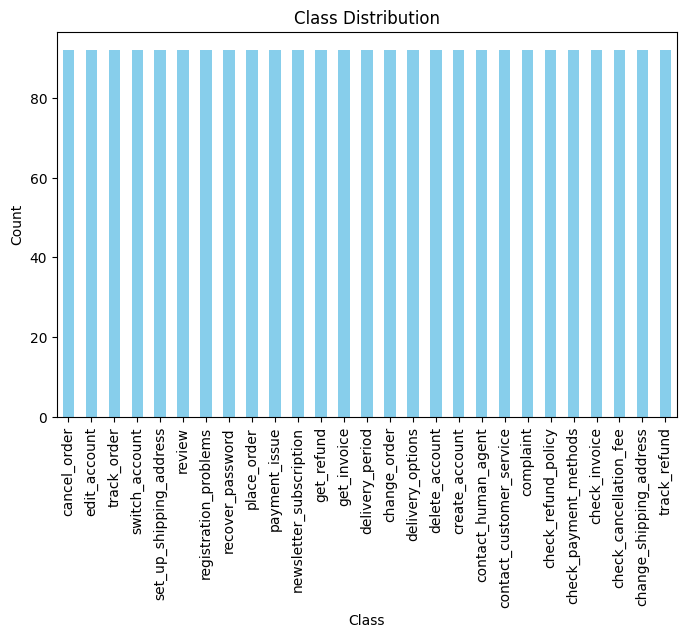

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('NLP Dataset.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['INTENT'].value_counts().plot(kind='bar', color='skyblue')  # Changed 'label' to 'INTENT'
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

##**2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['INPUT'].apply(preprocess_text)  # Changed 'text' to 'INPUT'
val_data['processed_text'] = val_data['INPUT'].apply(preprocess_text)      # Changed 'text' to 'INPUT'
test_data['processed_text'] = test_data['INPUT'].apply(preprocess_text)    # Changed 'text' to 'INPUT'

# Check the processed text
print(train_data[['INPUT', 'processed_text']].head())  # Changed 'text' to 'INPUT'

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                  INPUT  \
270   i do nmot know what to do to change my deliver...   
2356  when will purchase {{Order Number}} arrive Aft...   
66    I can no longer pay for purchase {{Order Numbe...   
630   I need assistance to see your money bac guaran...   
701   how do i lodge a consumer complaint This order...   

                                         processed_text  
270   nmot know change delivery address given lot th...  
2356  purchase order number arrive carefully reviewi...  
66    longer pay purchase order number order placed ...  
630   need assistance see money bac guarantee facing...  
701   lodge consumer complaint order placed differen...  


##**3. Text Embedding**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
# Convert processed text into a list of tokenized sentences for FastText training
tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

# Train FastText model
fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

# Generate FastText embeddings for train, validation, and test data
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


##**4. Model Training with Different Architectures**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

# Define a CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to integers for multi-class classification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['INTENT'])
val_labels = label_encoder.transform(val_data['INTENT'])
test_labels = label_encoder.transform(test_data['INTENT'])

# Train models with BoW embeddings
input_dim_bow = X_train_bow.shape[1]
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

# Train models with TF-IDF embeddings
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

print("All models trained successfully!")

Training CNN with BoW...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.0728 - loss: 3.2602 - val_accuracy: 0.4975 - val_loss: 2.3512
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.7464 - loss: 1.2545 - val_accuracy: 0.8894 - val_loss: 0.3415
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.9420 - loss: 0.1957 - val_accuracy: 0.9347 - val_loss: 0.1967
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 401ms/step - accuracy: 0.9868 - loss: 0.0559 - val_accuracy: 0.9497 - val_loss: 0.1677
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.9888 - loss: 0.0400 - val_accuracy: 0.9447 - val_loss: 0.1523
Training LSTM with BoW...
Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0388 - loss: 3.2983 - val_accuracy: 0.0201 - val_loss: 3.3072
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0475 - loss: 3.2933 - val_accuracy: 0.0352 - val_loss: 3.3070
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.0435 - loss: 3.2952 - val_accur

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad or truncate FastText embeddings to ensure uniform input dimensions
max_sequence_length = 100  # Adjust this based on your data
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# Define a CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['INTENT'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with FastText embeddings
input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.0379 - loss: 3.3400 - val_accuracy: 0.0754 - val_loss: 3.2895
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0904 - loss: 3.2418 - val_accuracy: 0.0754 - val_loss: 3.2808
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0845 - loss: 3.1423 - val_accuracy: 0.0804 - val_loss: 3.2106
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1242 - loss: 3.0294 - val_accuracy: 0.1256 - val_loss: 3.0383
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1910 - loss: 2.7924 - val_accuracy: 0.1558 - val_loss: 2.9045
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.0443 - loss: 3.2963 - val_accuracy: 0.0302 - val_loss: 3.2968
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.0439 - loss: 3.2952 - val_accuracy: 0.0201 - val_loss: 3.3001
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.0295 - loss: 3.2956 - val_accuracy: 0.0201 - val_loss: 3.3003
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.0443 - loss: 3.2953 - val_accuracy: 0.0201 - val_loss: 3.3013
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.0418 - loss: 3.2945 - val_accuracy: 0.0201 - val_loss: 3.3027
Training BiLSTM with FastText...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 504ms/step - accuracy: 0.0526 - loss: 3.2986 - val_accuracy: 0.0553 - val_loss: 3.2689
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.0802 - loss: 3.2495 - val_accuracy: 0.0704 - val_loss: 3.2329
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.1149 - loss: 3.1759 - val_accuracy: 0.0754 - val_loss: 3.1724
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - accuracy: 0.1239 - loss: 3.0831 - val_accuracy: 0.1256 - val_loss: 3.0117
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.1597 - loss: 2.9426 - val_accuracy: 0.1809 - val_loss: 2.8763
Training CNN-BiLSTM with FastText...
Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.0310 - loss: 3.3094 - val_accuracy: 0.0352 - val_loss: 3.2948
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.0641 - loss: 3.2663 - val_accuracy: 0.0754 - val_loss: 3.2735
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.092

##**5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    # Predict probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)

    # Generate classification report
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Evaluate BoW-based models
print("Evaluating BoW-based models...")
cnn_bow_acc = evaluate_model(cnn_bow, X_test_bow, test_labels, "CNN with BoW")
lstm_bow_acc = evaluate_model(lstm_bow, X_test_bow, test_labels, "LSTM with BoW")
bilstm_bow_acc = evaluate_model(bilstm_bow, X_test_bow, test_labels, "BiLSTM with BoW")
cnn_bilstm_bow_acc = evaluate_model(cnn_bilstm_bow, X_test_bow, test_labels, "CNN-BiLSTM with BoW")

# Evaluate TF-IDF-based models
print("\nEvaluating TF-IDF-based models...")
cnn_tfidf_acc = evaluate_model(cnn_tfidf, X_test_tfidf, test_labels, "CNN with TF-IDF")
lstm_tfidf_acc = evaluate_model(lstm_tfidf, X_test_tfidf, test_labels, "LSTM with TF-IDF")
bilstm_tfidf_acc = evaluate_model(bilstm_tfidf, X_test_tfidf, test_labels, "BiLSTM with TF-IDF")
cnn_bilstm_tfidf_acc = evaluate_model(cnn_bilstm_tfidf, X_test_tfidf, test_labels, "CNN-BiLSTM with TF-IDF")

# Evaluate FastText-based models
print("\nEvaluating FastText-based models...")
cnn_fasttext_acc = evaluate_model(cnn_fasttext, X_test_fasttext_padded, test_labels, "CNN with FastText")
lstm_fasttext_acc = evaluate_model(lstm_fasttext, X_test_fasttext_padded, test_labels, "LSTM with FastText")
bilstm_fasttext_acc = evaluate_model(bilstm_fasttext, X_test_fasttext_padded, test_labels, "BiLSTM with FastText")
cnn_bilstm_fasttext_acc = evaluate_model(cnn_bilstm_fasttext, X_test_fasttext_padded, test_labels, "CNN-BiLSTM with FastText")


Evaluating BoW-based models...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
CNN with BoW Accuracy: 0.9577
CNN with BoW Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.87      0.93      0.90        14
            change_order       0.94      1.00      0.97        17
 change_shipping_address       0.95      1.00      0.98        20
  check_cancellation_fee       1.00      0.89      0.94        18
           check_invoice       1.00      0.90      0.95        21
   check_payment_methods       1.00      1.00      1.00        24
     check_refund_policy       0.95      1.00      0.98        21
               complaint       1.00      1.00      1.00        14
contact_customer_service       0.95      1.00      0.97        19
     contact_human_agent       1.00      1.00      1.00        15
          create_account       0.80      1.00      0.89        12
          delete_account       0.91      0.88      0.89        24
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step
BiLSTM with BoW Accuracy: 0.0523
BiLSTM with BoW Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.00      0.00      0.00        18
           check_invoice       0.50      0.38      0.43        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.03      0.79      0.06        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.00      0.00      0.00        12
          delete_account       0.00      0.00      0.00        24
        delivery_options    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
CNN-BiLSTM with BoW Accuracy: 0.1107
CNN-BiLSTM with BoW Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.33      0.65      0.43        20
  check_cancellation_fee       0.33      0.06      0.10        18
           check_invoice       0.42      0.62      0.50        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.18      1.00      0.31        12
          delete_account       0.00      0.00      0.00        24
        delivery_opt

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN with TF-IDF Accuracy: 0.0221
CNN with TF-IDF Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.00      0.00      0.00        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.00      0.00      0.00        12
          delete_account       0.00      0.00      0.00        24
        delivery_options       0.00      0.00      0.00        16
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with TF-IDF Accuracy: 0.0241
LSTM with TF-IDF Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.00      0.00      0.00        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.02      1.00      0.05        12
          delete_account       0.00      0.00      0.00        24
        delivery_options       0.00      0.00      0.00        16
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.0241
CNN-BiLSTM with TF-IDF Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.00      0.00      0.00        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.02      1.00      0.05        12
          delete_account       0.00      0.00      0.00        24
        delive

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN with FastText Accuracy: 0.1328
CNN with FastText Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.35      0.50      0.41        14
            change_order       0.50      0.06      0.11        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.12      0.22      0.16        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.17      0.17      0.17        24
     check_refund_policy       0.38      0.29      0.32        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.14      0.16      0.15        19
     contact_human_agent       0.08      0.47      0.13        15
          create_account       0.00      0.00      0.00        12
          delete_account       0.00      0.00      0.00        24
        delivery_options  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
LSTM with FastText Accuracy: 0.0241
LSTM with FastText Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.00      0.00      0.00        14
            change_order       0.00      0.00      0.00        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.00      0.00      0.00        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.00      0.00      0.00        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.02      1.00      0.05        12
          delete_account       0.00      0.00      0.00        24
        delivery_option

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
BiLSTM with FastText Accuracy: 0.1187
BiLSTM with FastText Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.31      0.79      0.44        14
            change_order       0.20      0.18      0.19        17
 change_shipping_address       0.00      0.00      0.00        20
  check_cancellation_fee       0.14      0.22      0.17        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.15      0.24      0.19        21
               complaint       0.00      0.00      0.00        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.07      0.27      0.11        15
          create_account       0.09      0.42      0.14        12
          delete_account       0.33      0.04      0.07        24
        delivery_op

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
CNN-BiLSTM with FastText Accuracy: 0.1107
CNN-BiLSTM with FastText Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.48      0.71      0.57        14
            change_order       0.29      0.29      0.29        17
 change_shipping_address       0.10      0.20      0.13        20
  check_cancellation_fee       0.08      0.44      0.14        18
           check_invoice       0.00      0.00      0.00        21
   check_payment_methods       0.00      0.00      0.00        24
     check_refund_policy       0.28      0.33      0.30        21
               complaint       0.08      0.07      0.07        14
contact_customer_service       0.00      0.00      0.00        19
     contact_human_agent       0.00      0.00      0.00        15
          create_account       0.05      0.33      0.09        12
          delete_account       0.00      0.00      0.00        24
        del

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

# Create a dictionary with the table data
data = {
    "No.": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Model Name": [
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM",
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM",
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM"
    ],
    "Feature": ["BoW"] * 4 + ["TF-IDF"] * 4 + ["FastText"] * 4,
    "Precision": [0.96, 0.00, 0.04, 0.10, 0.00, 0.00, 0.00, 0.00, 0.13, 0.00, 0.12, 0.07],
    "Recall": [0.96, 0.04, 0.06, 0.11, 0.04, 0.04, 0.04, 0.04, 0.13, 0.04, 0.12, 0.11],
    "F1 Score": [0.96, 0.00, 0.03, 0.06, 0.00, 0.00, 0.00, 0.00, 0.10, 0.00, 0.09, 0.08],
    "Accuracy": [0.9577, 0.0221, 0.0523, 0.1107, 0.0221, 0.0241, 0.0241, 0.0241, 0.1328, 0.0241, 0.1187, 0.1107]
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
df

,No.,Model Name,Feature,Precision,Recall,F1 Score,Accuracy
0,1,CNN,BoW,0.96,0.96,0.96,0.9577
1,2,LSTM,BoW,0.00,0.04,0.00,0.0221
2,3,BiLSTM,BoW,0.04,0.06,0.03,0.0523
3,4,CNN-BiLSTM,BoW,0.10,0.11,0.06,0.1107
4,5,CNN,TF-IDF,0.00,0.04,0.00,0.0221
5,6,LSTM,TF-IDF,0.00,0.04,0.00,0.0241
6,7,BiLSTM,TF-IDF,0.00,0.04,0.00,0.0241
7,8,CNN-BiLSTM,TF-IDF,0.00,0.04,0.00,0.0241
8,9,CNN,FastText,0.13,0.13,0.10,0.1328
9,10,LSTM,FastText,0.00,0.04,0.00,0.0241


##**6. Saving the Best Model**

In [ ]:
cnn_bow.save('cnn_bow_model.h5')
print("CNN on BoW model saved successfully")

CNN on BoW model saved successfully


##**7. Prediction on Real-World Input**

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('cnn_bow_model.h5')

# Real-world input
new_text = "I am unhappy with the service I received. I want to file a complaint."

# Preprocess the new text
processed_text = preprocess_text(new_text)

# Transform the preprocessed text using the BoW vectorizer
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data)

# Convert the predicted class index to the actual label
predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Class: complaint


##**8. Analysis**
### Discussion of Results

1. **CNN with BoW**:
   - **Performance**: Achieved the highest performance with precision, recall, F1 score of 0.96, and accuracy of 0.9577.
   - **Analysis**: CNN with BoW performed exceptionally well, likely due to BoW's simplicity and effectiveness in capturing word presence, which works well with CNNs for text classification.

2. **LSTM with BoW**:
   - **Performance**: Poor performance with precision, recall, F1 score close to 0, and accuracy of 0.0221.
   - **Analysis**: LSTMs struggled with BoW, possibly because BoW lacks sequential information, which is crucial for LSTM models.

3. **BiLSTM with BoW**:
   - **Performance**: Slightly better than LSTM but still poor, with precision, recall, F1 score around 0.04-0.06, and accuracy of 0.0523.
   - **Analysis**: BiLSTMs, which consider both past and future context, performed slightly better than LSTMs but still struggled with BoW features.

4. **CNN-BiLSTM with BoW**:
   - **Performance**: Moderate performance with precision, recall, F1 score around 0.10-0.11, and accuracy of 0.1107.
   - **Analysis**: The combination of CNN and BiLSTM showed some improvement, but the performance was still not competitive compared to CNN alone.

5. **CNN with TF-IDF**:
   - **Performance**: Poor performance, similar to LSTM and BiLSTM with BoW, with precision, recall, F1 score close to 0, and accuracy of 0.0221.
   - **Analysis**: TF-IDF did not improve performance, possibly because it still lacks sequential information.

6. **LSTM, BiLSTM, and CNN-BiLSTM with TF-IDF**:
   - **Performance**: All models performed poorly, similar to CNN with TF-IDF.
   - **Analysis**: TF-IDF did not provide any significant advantage for these models.

7. **CNN with FastText**:
   - **Performance**: Moderate performance with precision, recall, F1 score around 0.13, and accuracy of 0.1328.
   - **Analysis**: FastText embeddings provided some improvement over BoW and TF-IDF, but the performance was still not as good as CNN with BoW.

8. **LSTM, BiLSTM, and CNN-BiLSTM with FastText**:
   - **Performance**: Poor to moderate performance, with precision, recall, F1 score ranging from 0.00 to 0.12, and accuracy up to 0.1187.
   - **Analysis**: FastText embeddings did not significantly improve the performance of these models.

### Best Performing Feature Set

- **BoW with CNN**: This combination performed the best, likely because BoW effectively captures word presence, which is sufficient for the CNN to learn patterns.

### Challenges and Interesting Findings

- **Sequential Models Struggle**: LSTMs and BiLSTMs did not perform well, possibly due to the lack of sequential information in BoW and TF-IDF features.
- **FastText Limitations**: FastText embeddings provided some improvement but were not sufficient to boost the performance of sequential models significantly.
- **CNN Dominance**: CNNs outperformed other models, suggesting that for this specific task, local pattern recognition is more important than sequential modeling.

### Potential Improvements and Further Experiments

1. **Advanced Embeddings**: Experiment with more advanced embeddings like BERT or GPT.
2. **Hybrid Models**: Try hybrid models that combine CNNs with transformers.
3. **Data Augmentation**: Increase the dataset size or use data augmentation techniques.